In [2]:
%pip install openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 kB 2.0 MB/s eta 0:00:00


Epoch 1/25
979/979 [==============================] - 11s 10ms/step - loss: 0.0092 - val_loss: 0.0096
Epoch 2/25
979/979 [==============================] - 8s 8ms/step - loss: 0.0055 - val_loss: 0.0050
Epoch 3/25
979/979 [==============================] - 8s 9ms/step - loss: 0.0051 - val_loss: 0.0061
Epoch 4/25
979/979 [==============================] - 9s 9ms/step - loss: 0.0048 - val_loss: 0.0078
Epoch 5/25
979/979 [==============================] - 10s 10ms/step - loss: 0.0046 - val_loss: 0.0069
Epoch 6/25
979/979 [==============================] - 9s 9ms/step - loss: 0.0044 - val_loss: 0.0059
Epoch 7/25
979/979 [==============================] - 10s 10ms/step - loss: 0.0043 - val_loss: 0.0063
Epoch 8/25
979/979 [==============================] - 10s 10ms/step - loss: 0.0042 - val_loss: 0.0102
Epoch 9/25
979/979 [==============================] - 9s 9ms/step - loss: 0.0041 - val_loss: 0.0068
Epoch 10/25
979/979 [==============================] - 9s 9ms/step - loss: 0.0040 - val_loss

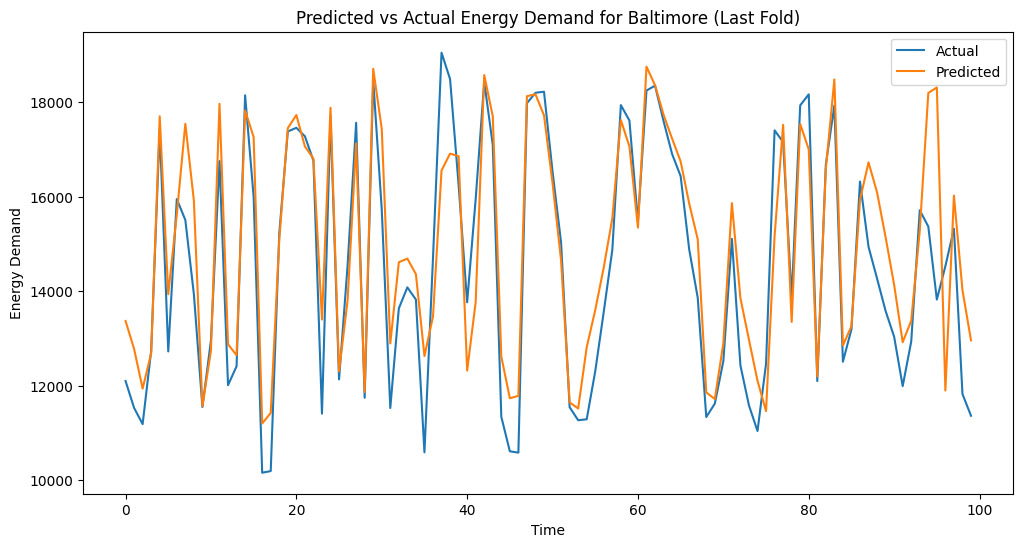

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error

df = pd.read_excel('Houston.xlsx')
df = df.dropna()

features = df[['Temperature', 'DewPoint', 'RelativeHumidity', 'Precipitation', 'WindSpeed', 'Pressure']].values
energy_demand = df['EnergyDemand'].values.reshape(-1, 1)
dates = df['Time'].values

scaler_features = MinMaxScaler()
scaler_energy = MinMaxScaler()
features_normalized = scaler_features.fit_transform(features)
energy_demand_normalized = scaler_energy.fit_transform(energy_demand)

def create_sequences(data, target, dates, seq_length):
    sequences = []
    targets = []
    sequence_dates = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        target_seq = target[i+seq_length]
        date_seq = dates[i+seq_length]
        sequences.append(seq)
        targets.append(target_seq)
        sequence_dates.append(date_seq)
    return np.array(sequences), np.array(targets), np.array(sequence_dates)

seq_length = 24
X, y, dates_seq = create_sequences(features_normalized, energy_demand_normalized, dates, seq_length)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

mse_scores = []
mae_scores = []
mape_scores = []

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_indices = y_true != 0
    return np.mean(np.abs((y_true[non_zero_indices] - y_pred[non_zero_indices]) / y_true[non_zero_indices])) * 100

result_df = pd.DataFrame()

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    dates_test = dates_seq[test_index]

    model = Sequential([
        LSTM(50, activation='relu', input_shape=(seq_length, X.shape[2])),
        Dense(1)
    ])

    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

    history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_split=0.1, verbose=1)

    predictions_normalized = model.predict(X_test)

    predictions = scaler_energy.inverse_transform(predictions_normalized)
    y_test_original = scaler_energy.inverse_transform(y_test)

    mse = mean_squared_error(y_test_original, predictions)
    mae = mean_absolute_error(y_test_original, predictions)
    mape = mean_absolute_percentage_error(y_test_original, predictions)
    mse_scores.append(mse)
    mae_scores.append(mae)
    mape_scores.append(mape)

    fold_results = pd.DataFrame({
        'Date': dates_test,
        'Actual': y_test_original.flatten(),
        'Predicted': predictions.flatten()
    })
    result_df = pd.concat([result_df, fold_results], ignore_index=True)

result_df.to_csv('houston_predictions.csv', index=False)

average_mse = np.mean(mse_scores)
average_mae = np.mean(mae_scores)
average_mape = np.mean(mape_scores)
print(f"Average Mean Squared Error: {average_mse}")
print(f"Average Mean Absolute Error: {average_mae}")
print(f"Average Mean Absolute Percentage Error: {average_mape}")

plt.figure(figsize=(12, 6))
plt.plot(result_df['Actual'][:100], label='Actual')
plt.plot(result_df['Predicted'][:100], label='Predicted')
plt.title('Predicted vs Actual Energy Demand for Baltimore (Last Fold)')
plt.xlabel('Time')
plt.ylabel('Energy Demand')
plt.legend()
plt.show()